temp   focus
17.56  36.3
8.84   35.2

In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.images.processors.background import DaophotBackground, SepBackground
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from photutils.centroids import centroid_quadratic

from plotimg import plot_images

from cluplus.proxy  import invoke
from cluplus.proxy import Proxy


In [2]:
from plotimg import plot_images

async def focus_calc(focus, radius_data, images, source_detection):

    for idx, img in enumerate(images):
        images[idx].data = median_filter(images[idx].data, size=2)
        
        # photutils.background
#        bkg_estimator = MedianBackground()
#        bkg = Background2D(img.data.astype(float), (50, 50), filter_size=(3, 3),
#                           bkg_estimator=bkg_estimator)
#        images[idx].data = images[idx].data.astype(float) - bkg.background
#        bkg_median = np.median(bkg.background)
#        bkg_std = np.std(bkg.background)

        # sep.background
#        images[idx].bkg = sep.Background(images[idx].data.astype(float))
#        images[idx].data = images[idx].data.astype(float) - images[idx].bkg
#        bkg_median = np.median(images[idx].bkg)
#        bkg_std = np.std(bkg_median)

        bkg = DaophotBackground()(images[idx])
        images[idx].data = images[idx].data - bkg
        bkg_median = np.median(bkg)
        bkg_std = np.std(bkg)


    for idx, img in enumerate(images):
        images[idx] = source_detection(img)
#        images[idx].catalog.sort("fwhm")
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] > bkg_median + (1 * bkg_std) ]
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] < 65000]
        images[idx].catalog = images[idx].catalog[images[idx].catalog["ellipticity"] < 0.5]
        images[idx].catalog.sort("flux")
        images[idx].catalog.reverse()

        sources = images[idx].catalog
        if (len(sources) > 2):
            radius = np.median(sources[column][:num_stars])
            radius_err = np.std(sources[column][:num_stars])
            radius_data[idx].append({"focus": focus, "r": radius, "rerr": radius_err})

    return bkg_median, bkg_std


In [3]:
from lvmagp.focus.curvefit import fit_hyperbola

def focus_plot(images, data):
    #print(data)

    fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(8, 5/len(data)))

    for idx, dd in enumerate(data):
        focus = [d["focus"] for d in dd]
        r = [d["r"] for d in dd]
        rerr = [d["rerr"] for d in dd]

        ax_idx = ax[idx] if len(data) > 1 else ax
        ax_idx.set_title(images[idx].header["CAMNAME"])
        ax_idx.errorbar(focus, r, yerr=rerr)

        fit_focus, fit_err = fit_hyperbola(focus, r, rerr)
        
    return fit_focus, fit_err


[WARNING]: actor lvm.sci.tel currently not reachable.
[WARNING]: coroutine 'Proxy.call_command' was never awaited (RuntimeWarning)


no temperature actor
 focus: 40.5 file: ['/data/lvm/sci/agcam/east/20230208/lvm.sci.agcam.east_00000006.fits', '/data/lvm/sci/agcam/center/20230208/lvm.sci.agcam.center_00000006.fits', '/data/lvm/sci/agcam/west/20230208/lvm.sci.agcam.west_00000006.fits']


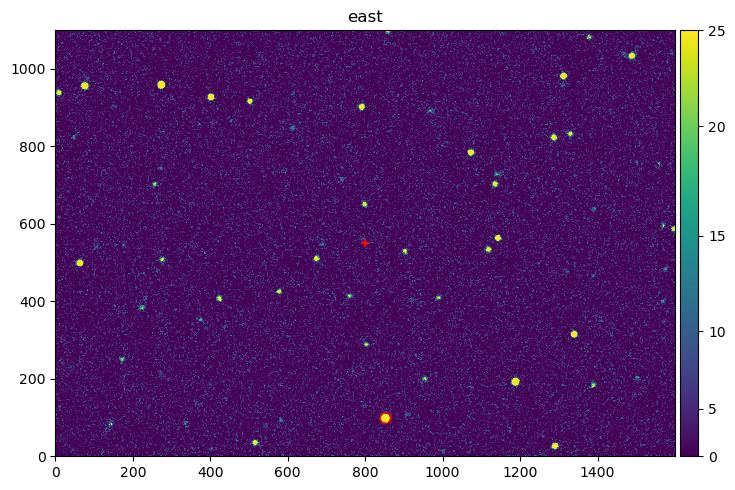

 focus: 41.166666666666664 file: ['/data/lvm/sci/agcam/east/20230208/lvm.sci.agcam.east_00000007.fits', '/data/lvm/sci/agcam/center/20230208/lvm.sci.agcam.center_00000007.fits', '/data/lvm/sci/agcam/west/20230208/lvm.sci.agcam.west_00000007.fits']


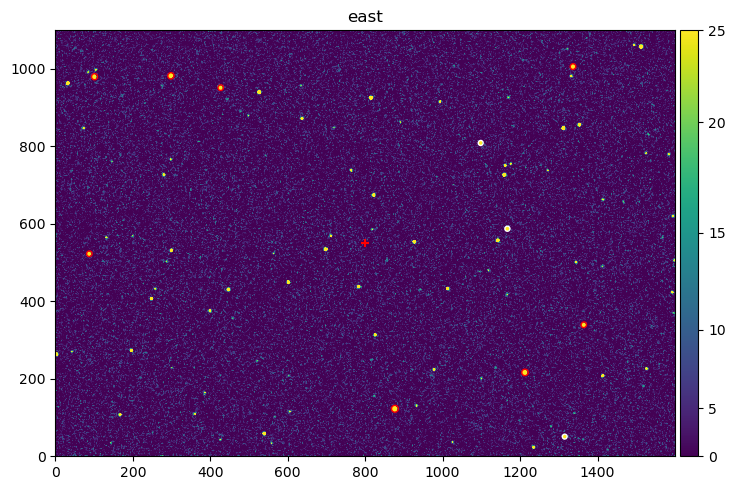

 focus: 41.833333333333336 file: ['/data/lvm/sci/agcam/east/20230208/lvm.sci.agcam.east_00000008.fits', '/data/lvm/sci/agcam/center/20230208/lvm.sci.agcam.center_00000008.fits', '/data/lvm/sci/agcam/west/20230208/lvm.sci.agcam.west_00000008.fits']


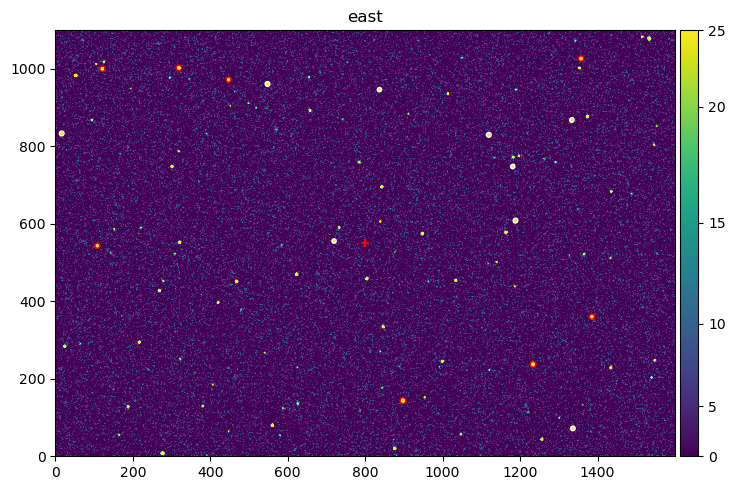

 focus: 42.5 file: ['/data/lvm/sci/agcam/east/20230208/lvm.sci.agcam.east_00000009.fits', '/data/lvm/sci/agcam/center/20230208/lvm.sci.agcam.center_00000009.fits', '/data/lvm/sci/agcam/west/20230208/lvm.sci.agcam.west_00000009.fits']


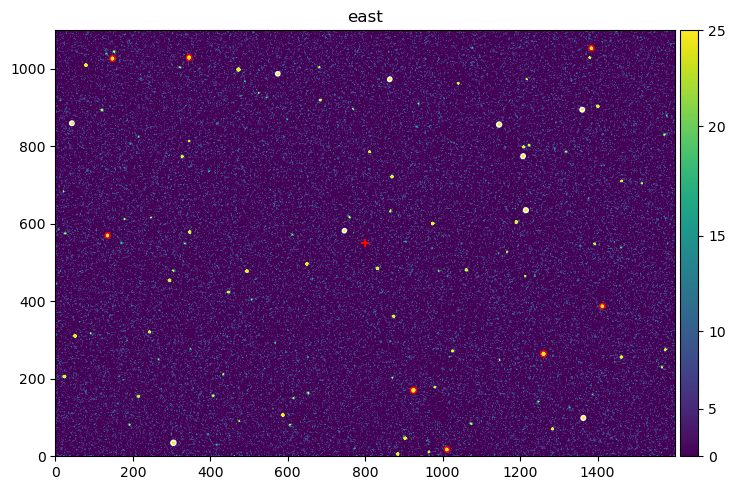

[WARNING]: Covariance of the parameters could not be estimated (OptimizeWarning)


move focus: 41.99009873295702


{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 254,
 'Position': 41.99009873295702,
 'DeviceEncoder': {'Position': 995.0493664785099, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}

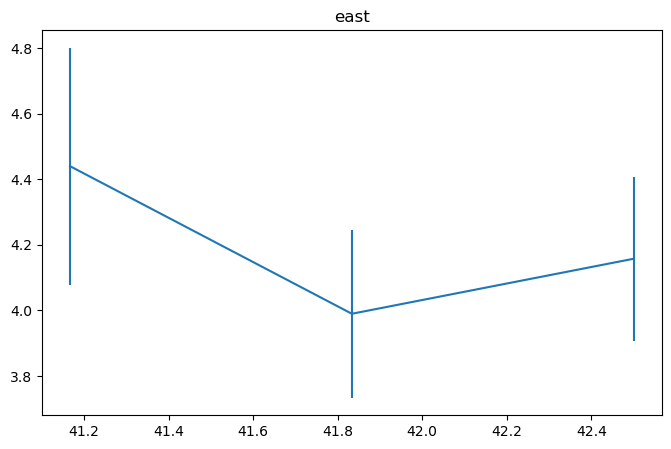

In [4]:
%matplotlib inline
#%matplotlib widget

from lvmtipo.actors import lvm
from lvmtipo.focus import temp2focus

threshold = 12.0
minarea = 24.0
deblend_nthresh = 1.4

source_detection = SepSourceDetection(threshold= threshold, minarea=minarea, deblend_nthresh=deblend_nthresh)

num_stars = 8
column = "fwhm"

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()

await lvm.sci.agc.start()

lvm.sci.tel = await Proxy("lvm.sci.tel").start()

try:
    focus_guess=temp2focus(await(lvm.sci.tel.status()).flatten().unpack("temperature"))
except Exception as ex:
    print("no temperature actor")
    focus_guess=41.5

radius_data = None
expotime = 5.0

for focus in np.linspace(focus_guess-1, focus_guess+1, num=4):
    await lvm.sci.foc.moveAbsolute(focus, "DT")    
    filenames = (await lvm.sci.agc.expose(expotime)).flatten().unpack("*.filename")
    print(f" focus: {focus} file: {filenames}")
    images = [[Image.from_file(f) for f in filenames][0]]

    if not radius_data: radius_data = [list()]*len(images)
    await focus_calc(focus, radius_data, images, source_detection)
    plot_images(images, cat_max=num_stars, cat_rest=True)

fit_focus, fit_err = focus_plot(images, radius_data)

print (f"move focus: {fit_focus}")
await lvm.sci.foc.moveAbsolute(fit_focus, "DT")



### Test

temp: 8.55 focus: 31.0 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000135.fits
 bkg_median: 374.41931357686894 bkg_std: 52.29291454234894
        x                  y                peak              flux               fwhm            ellipticity    
------------------ ----------------- ----------------- ------------------ ------------------ -------------------
1276.7610922611927 699.0104407059156 735.9087524414062 219583.94346821748 22.193676924717963  0.2023468953759785
1362.9884303556112 994.4435806958206  647.499267578125 194595.98923666886 22.159745896865417 0.19061109317983793
  768.736338119177  418.902432153185 540.4812622070312  158229.9050289575 21.488163368620377 0.23348816005738682
 903.0492033200113  483.386096016964 555.8998413085938  143234.2711698352  21.65637981146691  0.2599381935088497
None


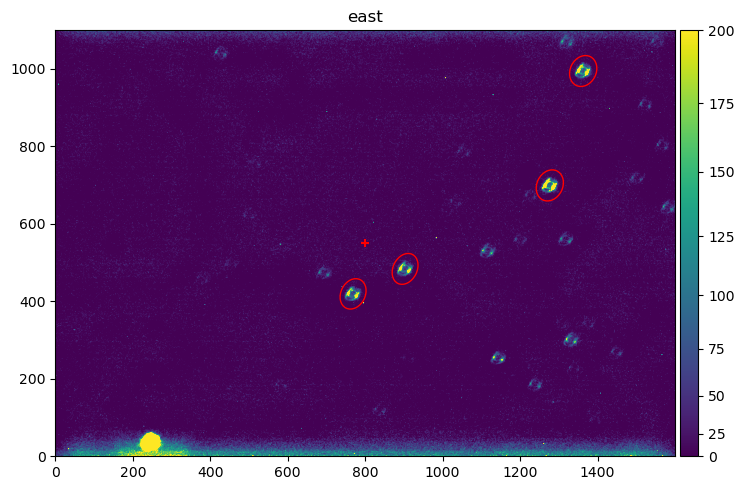

temp: 8.52 focus: 31.91 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000136.fits
 bkg_median: 369.7035259662678 bkg_std: 53.062815304240445
        x                  y                 peak              flux               fwhm            ellipticity    
------------------ ------------------ ----------------- ------------------ ------------------ -------------------
1276.3760815994858  698.0755275865065   981.49365234375 226435.33897237547 18.478718024461827 0.21289492770740703
1363.1638000323205   993.967812780692  810.249267578125 192086.01882727395 18.319613913099957 0.22029876686426253
 767.7592583220056 417.63188835659497 675.4556274414062 181040.29945192984 17.881005781740768 0.21450181268564883
 902.9941003993049 482.06825890745483 658.0396118164062  179096.3818464049 17.935264613048155 0.22775291041046952
None


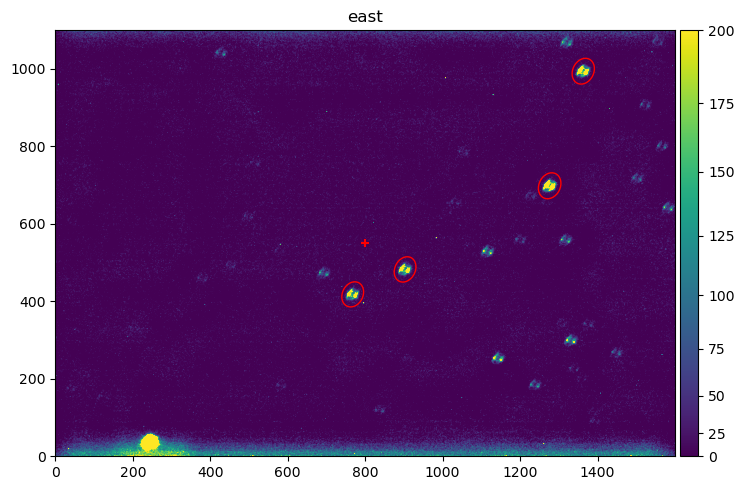

temp: 8.44 focus: 32.82 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000137.fits
 bkg_median: 368.4599485432532 bkg_std: 52.46070249243086
        x                  y                 peak               flux               fwhm            ellipticity    
------------------ ------------------ ------------------ ------------------ ------------------ -------------------
1276.2440301101055   695.526974764502  1199.991943359375 222275.77976429544  14.75823375569917 0.24500604507702883
1362.8927972222386  991.4684147375067   1103.69873046875 201858.60781876207 15.020311161666402 0.24266783264938607
 902.2440350704313 479.84526796480156   899.582275390625   163261.206768492 14.520950569954579  0.2621938615549515
 767.2430442904272 415.41120730959807      851.509765625 157614.53736651855 14.396342589957001 0.26403610281896805
1142.9244371744899 249.67788236026672  546.5347290039062  82830.12402116263 13.217541788544311 0.32279134643197427
1331.0412277681494   296.3

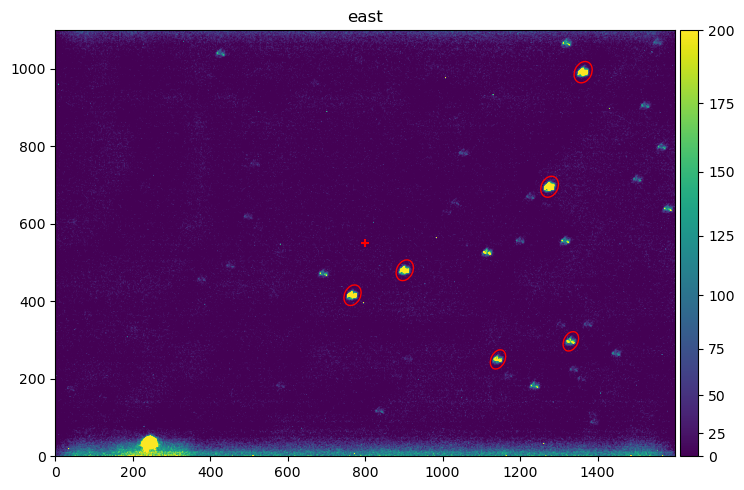

temp: 8.48 focus: 33.728 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000138.fits
 bkg_median: 368.12586088516935 bkg_std: 52.368551514272795
        x                  y                 peak              flux               fwhm            ellipticity    
------------------ ------------------ ----------------- ------------------ ------------------ -------------------
1275.2787465675506  694.3026050502045 1945.386474609375 235669.81083474637 11.481622890498516 0.27806801661629554
1362.1524509114101  990.2349525865615 1615.009521484375 200090.88592049482 11.420310261132514  0.2894586714050005
 900.9596558391376 478.93551635747673 1329.917724609375 158893.38193570802 11.076810845245042  0.3108589991165034
  765.813127121587 414.55330547573755  1311.83642578125  150261.9322845273 10.913924233397138 0.32210663701841735
 1141.734152459723 248.59397117984565      836.38671875   85713.5387831517  10.30796620330047 0.35213688949112076
1316.8151288016268  554.681177

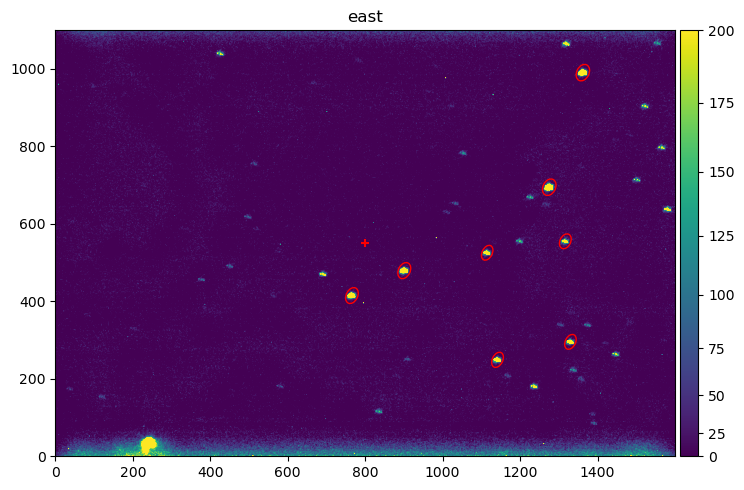

temp: 8.48 focus: 34.638 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000139.fits
 bkg_median: 368.13768296930255 bkg_std: 52.1169950615653
        x                  y                 peak               flux               fwhm           ellipticity    
------------------ ------------------ ------------------ ------------------ ----------------- -------------------
1274.6969691133124  691.7533787063809     2075.822265625 237673.79759515836 9.873682916908756 0.26571203872158744
1361.8012788757653  987.6762911454352 1793.5633544921875 199373.91411354716 9.567496705789832  0.2807933712733576
 900.2682448593008 476.57858954857124 1341.8480224609375 148905.53925774994  9.44198669296994 0.28969245066802274
 764.7851379463343  412.2689803672966 1372.3431396484375 146221.63861895562 9.253666345399798  0.2888289053378633
1140.8539424315013 246.00930446610394   873.224365234375  88432.70816544056 9.012132107652112  0.3038503759216086
1329.3534829006908  292.33785235

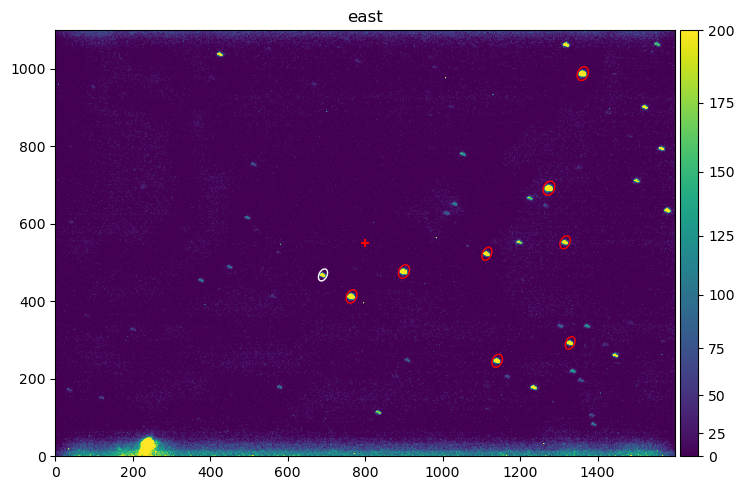

temp: 8.5 focus: 35.546 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000140.fits
 bkg_median: 368.16589160186567 bkg_std: 51.867214094766176
        x                  y                 peak               flux               fwhm            ellipticity    
------------------ ------------------ ------------------ ------------------ ------------------ -------------------
239.34646021465522 31.058453736463175      53394.7890625 3908797.6406683363 11.145983419200162 0.11110493715848135
1274.1286728865202  690.9037009330367      3480.42578125  230215.1384244156  9.052985288543306  0.3583569325394774
 1361.445767644498  986.8561253331686     2892.611328125 193678.34400203457  8.821477565419798 0.35625047500484375
 899.4395832991598  475.9493801231898   2336.16845703125 151121.37444081964  8.795203443670141 0.38494969616756525
 763.8924663069569 411.61374332930114  2301.501708984375 147551.74433796882  8.742173263875829  0.3709895281542843
 1140.106084698977  245.

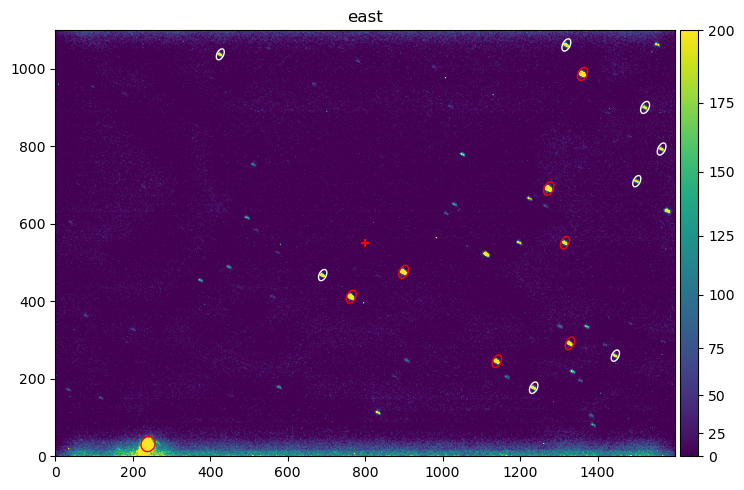

temp: 8.49 focus: 36.456 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000141.fits
 bkg_median: 368.11856293767033 bkg_std: 51.77889671439662
        x                  y                 peak               flux               fwhm            ellipticity    
------------------ ------------------ ------------------ ------------------ ------------------ -------------------
1273.8823490104655  688.9713569093152  2592.691650390625  220788.9668409991 10.693374988846216 0.40317864332425324
 1361.326664713754   984.943208412491   2318.53369140625 187047.87292594416 10.497177241555113 0.38850384340644406
  898.871482709283 474.25364238100326 1728.1688232421875 147767.41393156763 10.627292021607365 0.38909576542748237
 763.1869531168536 409.95755752397974 1630.9649658203125  145366.6480445862 10.498245239718441   0.380269866943039
1139.3177722580976  243.1912539937663 1078.0313720703125  86296.29617285906 10.245135614216302  0.3867139405198209
1315.1711672427589  549.

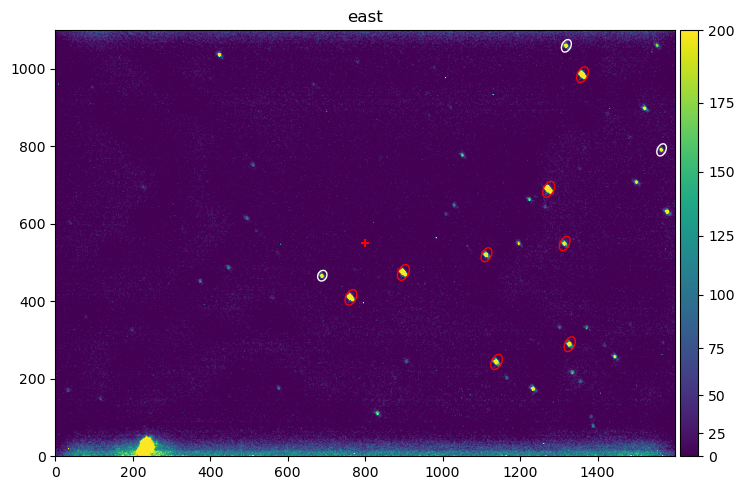

temp: 8.54 focus: 37.364 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000142.fits
 bkg_median: 368.1761192839368 bkg_std: 52.121840329263605
        x                  y                 peak               flux               fwhm            ellipticity    
------------------ ------------------ ------------------ ------------------ ------------------ -------------------
1273.6120661639338  687.0816845639674    2376.4111328125 228838.74855877872 13.742433079815394  0.3480223221278289
1361.2860539339144  983.2562429904656  2256.563232421875  188128.1948774879   13.2238054659029 0.36432153653620536
 898.1043089978899  472.5436459200046 1601.0262451171875 146642.84635302838  13.35057597311798 0.35084452111542086
 762.3654009746381  408.2699825186845 1564.3092041015625 143598.72196195603 12.948995962318989 0.32343975541217485
1138.4561055112022 241.24865388419283     996.3251953125  86605.36238026261 11.924732968088984  0.2846575117953365
1327.3150202263382  286.

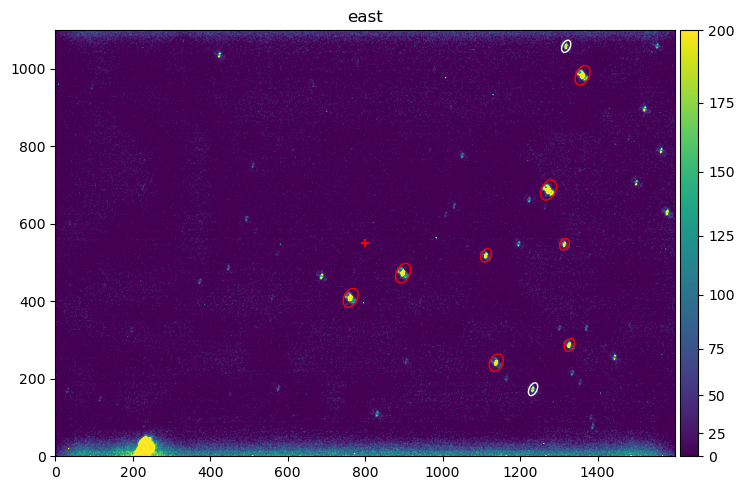

temp: 8.52 focus: 38.274 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000143.fits
 bkg_median: 383.0459126257329 bkg_std: 52.46096915815825
        x                  y                 peak               flux               fwhm            ellipticity    
------------------ ------------------ ------------------ ------------------ ------------------ -------------------
1273.0309469847703  685.3577392284235  1329.852783203125 226420.19182139137 17.004018811604247  0.3283497414362573
1361.0012428711002  981.6202518780219 1174.0635986328125 183838.16710921188 16.633774984684223 0.33760606147703787
 897.7690738389044  471.0583936641084  924.0433349609375 156111.27871084152   16.3279408905733  0.3033975579711322
 760.5422025044694  408.0524304313372  902.5963134765625 131866.41822436306 13.699974966676693 0.25877600352447594
1137.8317769487062 239.76779538205915 481.81890869140625  86748.22323135483  11.72728076303608 0.47991980697629855
None


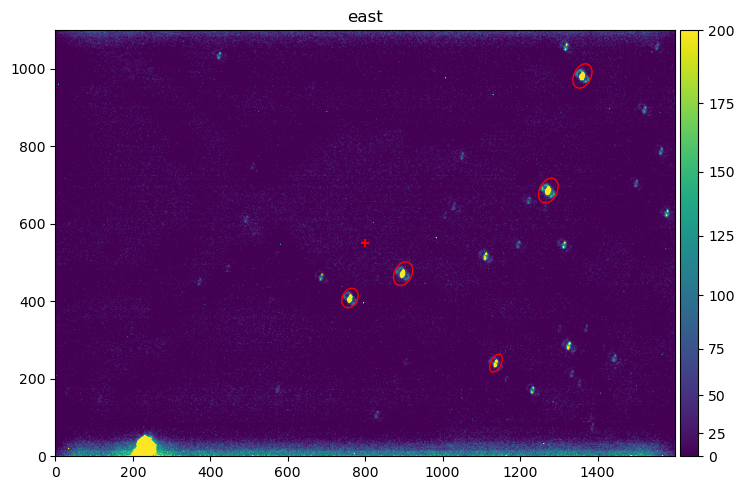

temp: 8.56 focus: 39.182 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000144.fits
 bkg_median: 416.0927422973502 bkg_std: 50.53507915565702
        x                  y                peak              flux               fwhm            ellipticity    
------------------ ----------------- ----------------- ------------------ ------------------ -------------------
1272.0808609345634  683.812274422028 1003.216552734375 216045.34988609137  19.91162481379453 0.28276075175475457
1360.1937713895013 980.9616354760251 975.2789916992188  169661.3065898913 15.605812906582353  0.4748180787846181
None


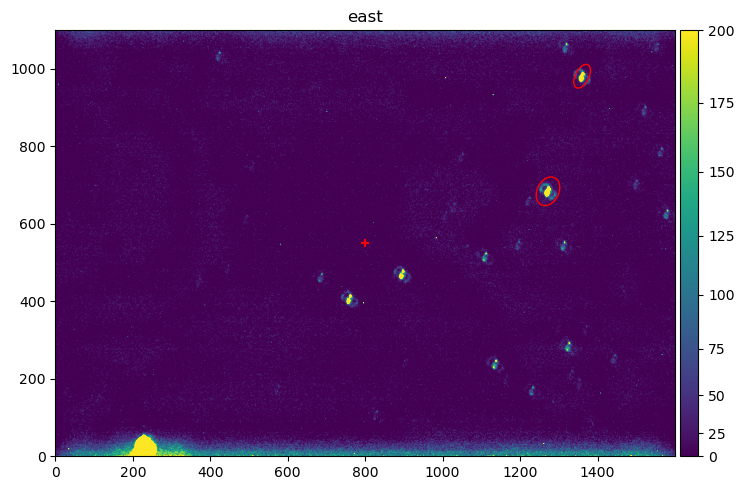

temp: 8.56 focus: 40.09 exptime: 10.0 file: /data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_00000145.fits
 bkg_median: 428.89086657790335 bkg_std: 53.22213309798277
        x                 y                peak              flux               fwhm           ellipticity    
----------------- ----------------- ----------------- ------------------ ------------------ ------------------
1271.206056441733 683.2509793643603 710.2833251953125 195328.10175103933 18.517970942431347 0.4695770417295233
None


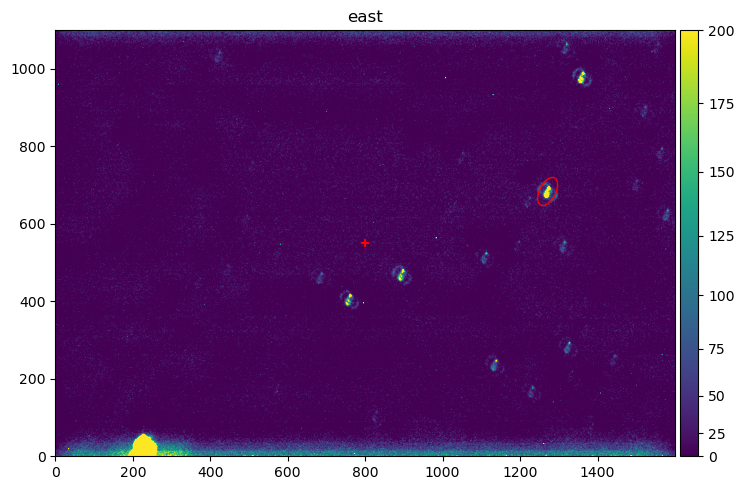

(35.238048347795264, 0.0021042981379793884)

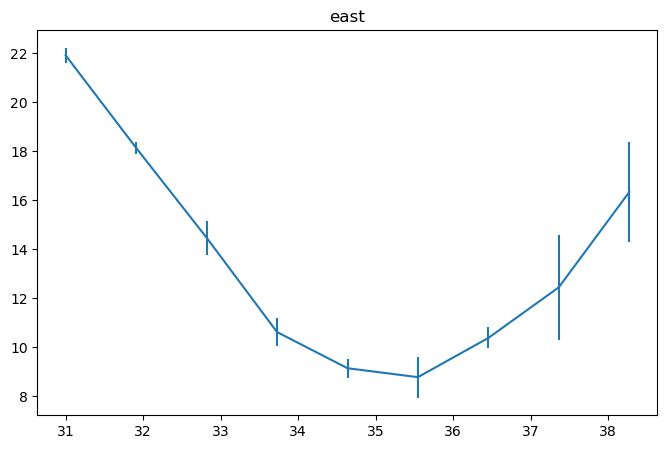

In [5]:
%matplotlib inline
#%matplotlib widget


#fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_{idx:08}.fits"

#off=400
#num=15

#off=404
#num=5

#off=391
#num=7

#off=392
#num=5

#off=319 # to short 36 - 38, 0.5
#num=5

#off=329 #bad
#num=5

#off=392
#num=5

#off=365
#num=1

#off=400
#num=14

#off=430
#num=14

#off=415
#num=14

#off=419
#num=5

fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_{idx:08}.fits"

#off=77
#num=5

#off=87 #bad
#num=6

#off=121
#num=6

#off=128
#num=7

off=135
num=11



threshold = 3.2
minarea = 24.0
deblend_nthresh = 1.2
deblend_cont = 0.01

num_stars = 8

source_detection = SepSourceDetection(threshold=threshold, minarea=minarea, deblend_nthresh=deblend_nthresh, deblend_cont=deblend_cont)
#source_detection = SepSourceDetection()
#source_detection = DaophotSourceDetection(fwhm=4, threshold=30)

column = "fwhm"

radius_data = [[]]


for i in range(num):
    images = [Image.from_file(fbase(i+off))]
    focus = images[0].header["FOCUSUM"]
    temp = images[0].header["BENTEMP"]
#    print(images[0].header)
    print(f"temp: {temp} focus: {focus} exptime: {images[0].header['EXPTIME']} file: {fbase(i+off)}")

    bkg_median, bkg_std = await focus_calc(focus, radius_data, images, source_detection)
    print(f" bkg_median: {bkg_median} bkg_std: {bkg_std}")
    cat=images[0].catalog[:num_stars]
    print(f"{cat['x', 'y', 'peak', 'flux', 'fwhm', 'ellipticity'].pprint(max_width=120)}")

    plot_images(images, cat_max=num_stars, cat_rest=True, vmax=200)

focus_plot(images, radius_data)
